In [1]:
import os
os.chdir('..')

In [2]:
path = os.getcwd()
print(path)

C:\Users\SAMSUNG\Documents\dacon\Dacon_dota


In [3]:
import numpy as np
import pandas as pd

import os #
import cv2 #이미지 안에서 원하는 이미지 인식
from glob import glob #동일한 형식을 갖춘 데이터를 불러오는 패키지 
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
train_images = sorted(glob('data/rawdata/train/images/*'))
train_jsons = sorted(glob('data/rawdata/train/json/*'))
test_images = sorted(glob('data/rawdata/test/images/*'))
len(train_images), len(train_jsons), len(test_images)

(800, 0, 100)

In [5]:
train_meta = []
for j in train_jsons:
    json_obj = json.load(open(j))
    for f in json_obj['features']:
        geo_coord = f['geometry']['coordinates']
        geo_type = f['geometry']['type']
        object_imcoords = f['properties']['object_imcoords']
        object_angle = f['properties']['object_angle']
        building_imcoords = f['properties']['building_imcoords']
        road_imcoords = f['properties']['road_imcoords']
        image_id = f['properties']['image_id']
        ingest_time = f['properties']['ingest_time']
        type_id = f['properties']['type_id']
        type_name = f['properties']['type_name']
        train_meta.append([image_id, type_id, type_name, geo_coord, geo_type, object_angle,
                           object_imcoords, building_imcoords, road_imcoords, ingest_time])

In [6]:
train = pd.DataFrame(train_meta,columns= ['image_id','type_id','type_name','geo_coord','geo_type','object_angle',
                                   'object_imcoords','building_imcoords','road_imcoords','ingest_time'])

In [7]:
train.head()

,image_id,type_id,type_name,geo_coord,geo_type,object_angle,object_imcoords,building_imcoords,road_imcoords,ingest_time


In [8]:
train['image_id'] = train['image_id'].apply(lambda x: x.split('.')[0])

In [9]:
train.building_imcoords.unique()

array([], dtype=object)

In [10]:
train.road_imcoords.unique()

array([], dtype=object)

In [11]:
train['geo_coord'].apply(lambda x: str(x)).unique()

array([], dtype=object)

In [12]:
train.geo_type.unique()

array([], dtype=object)

In [13]:
train = train.drop(['building_imcoords','road_imcoords','geo_coord','geo_type','ingest_time'],axis=1)

In [14]:
train.head()

,image_id,type_id,type_name,object_angle,object_imcoords


In [15]:
path = path.replace('\\','/')
train.to_csv(path+'/data/data.csv')

In [16]:
print('카테고리 종류 : ',train['type_name'].unique())
print('카테고리 수 : ', train['type_name'].nunique())

카테고리 종류 :  []
카테고리 수 :  0


In [17]:
df = pd.crosstab(train['image_id'], train['type_name'])
df = df.join(train.image_id.value_counts()).rename(columns={'image_id':'obj_count'})
df = df.join(train[['image_id','type_name']].drop_duplicates()['image_id'].value_counts()).rename(columns={'image_id':'obj_unique'})

In [18]:
df.head()

,obj_count,obj_unique


In [19]:
train.type_name.value_counts()

Series([], Name: type_name, dtype: int64)

- 데이터 불균형 문제를 어떻게 처리할 것인가? dam 같은 경우에는 3개 밖에 없어서 해당 test set이 들어오면 잘 처리하지 못할 것이다

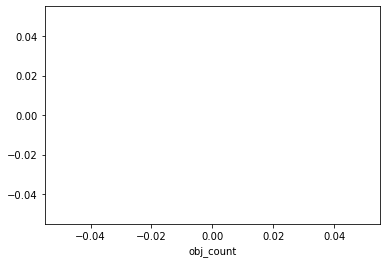

In [20]:
sns.distplot(df['obj_count'])

In [21]:
df['obj_count'].max()

nan

In [22]:
df[df['obj_count']>1000]

,obj_count,obj_unique


한 이미지에 나타나는 객체 수가 1000개가 넘는 경우는 7건.. 대부분 자동차나 트럭이다

In [23]:
df.obj_unique.max()

nan

한 이미지에 나타나는 최대 객체 종류는 8

In [24]:
train.head(1)

,image_id,type_id,type_name,object_angle,object_imcoords


In [25]:
for i in range(0,8,2):
    train['x'+str(int(i/2+1))] = train.object_imcoords.apply(lambda x: x.split(',')[i])

In [26]:
for i in range(1,9,2):
    train['y'+str(int((i+1)/2))] = train.object_imcoords.apply(lambda x: x.split(',')[i])

In [27]:
train.head()

,image_id,type_id,type_name,object_angle,object_imcoords,x1,x2,x3,x4,y1,y2,y3,y4


-좌표를 x1,x4 y1,y4로 각각 나누어서 새로운 column을 생성

In [28]:
imcoords_columns = []
imcoords_columns = train.columns[-8:-1]

In [29]:
type_id = train.type_id.drop_duplicates().sort_values().to_dict().values()
type_colors = dict(zip(type_id, plt.cm.tab20.colors))

In [30]:
'''
def show_n_mask(image_id, obj_type=None, gray_mode=True):
    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('train/images/'+image_id+'.png', cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in train[train.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():
        if (obj_type==row.type_name):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
'''

"\ndef show_n_mask(image_id, obj_type=None, gray_mode=True):\n    fig= plt.figure(figsize=(18,18))\n    # plot image\n    img = cv2.imread('train/images/'+image_id+'.png', cv2.COLOR_BGR2RGB)\n    if gray_mode:\n        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')\n    else:\n        plt.imshow(img)\n    \n    # All object or selected objects(obj_type)\n    for idx, row in train[train.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():\n        if (obj_type==row.type_name):\n            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])\n            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)\n            # Label 'type_id' 1~16\n            cx = row[imcoords_columns].values[::2].mean()\n            cy = row[imcoords_columns].values[1::2].mean()\n            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweig